### Arima

**ARIMA** stands for AutoRegressive Integrated Moving Average. It is a class of models that explains a given time series based on its own past values, namely its own lags and the lagged forecast errors, so that equation can be used to forecast future values. An ARIMA model is characterized by 3 terms: `p`, `d`, and `q`:
- **p** is the order of the AR term. It refers to the number of lags to be used as predictors.
- **d** is the order of differencing. It refers to the number of times the data have had past values subtracted.
- **q** is the order of the MA term. It refers to the number of lagged forecast errors in the prediction equation.

### Sarimax

**SARIMAX** stands for Seasonal AutoRegressive Integrated Moving Average with eXogenous variables
- Just like **ARIMA** but could be used with features other than the previous variable

### Target Variable 
- For testing, we want to predict the 7 day volatility

- [1. Importing Packages and Functions](#1)
- [2. Assembling Datasets and Adding Features for Sarimax](#2)
    - [2.1 Adding Features for SARIMAX](#2_1)
        - [2.1.1 RSI](#2_1_1)
        - [2.1.2 Stochastic RSI](#2_1_2)
        - [2.1.3 Volatility Ratio](#2_1_3)
        - [2.1.4 Location in Terms of STD](#2_1_4)
        - [2.1.5 Lasso to Select Features](#2_1_5)
- [3. Modeling](#3)
    - [3.1 ARIMA](#3_1)
        - [3.1.1 Hyperparameters Tuning for ARIMA](#3_1_1)
    - [3.2 Sarimax](#3_2)

## 1. Importing Packages and Functions <a id='1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from tqdm import tqdm
from itertools import product
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX




In [ ]:
def calculate_rsi(data, column='close', periods=14):
    """
    Calculate the Relative Strength Index (RSI) of a given DataFrame.
    
    Parameters:
    - data: pandas DataFrame containing the price data.
    - column: string, the name of the column with the price data.
    - periods: int, the number of periods to use for calculating RSI.
    
    Returns:
    - pd.Series: a pandas Series containing the RSI values.
    """
    # Compute price differences (gains/losses)
    delta = data[column].diff()

    # Separate gains and losses
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    # Calculate the average gain and loss
    average_gain = gain.rolling(window=periods, min_periods=periods).mean()
    average_loss = loss.rolling(window=periods, min_periods=periods).mean()

    # Calculate the Relative Strength (RS)
    rs = average_gain / average_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def calculate_stoch_rsi(data, column='close', periods=14, stoch_periods=14):
    """
    Calculate the Stochastic Relative Strength Index (StochRSI) of a given DataFrame.
    
    Parameters:
    - data: pandas DataFrame containing the price data.
    - column: string, the name of the column with the price data.
    - periods: int, the number of periods to use for calculating RSI.
    - stoch_periods: int, the number of periods to use for calculating StochRSI.
    
    Returns:
    - pd.Series: a pandas Series containing the StochRSI values.
    """
    # First, calculate RSI
    rsi = calculate_rsi(data, column=column, periods=periods)

    # Calculate StochRSI
    min_rsi = rsi.rolling(window=stoch_periods, min_periods=stoch_periods).min()
    max_rsi = rsi.rolling(window=stoch_periods, min_periods=stoch_periods).max()
    stoch_rsi = (rsi - min_rsi) / (max_rsi - min_rsi)

    return stoch_rsi


def evaluate_arima_model(X, arima_order, split_size=0.8):
    train_size = int(len(X) * split_size)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    aic = model_fit.aic
    return error, predictions, aic

def evaluate_models(dataset, p_values, d_values, q_values, split_size=0.8):
    dataset = dataset.astype('float32')
    model_results = []
    total_iterations = len(p_values) * len(d_values) * len(q_values)
    with tqdm(total=total_iterations, desc='Grid Search') as pbar:
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    order = (p, d, q)
                    try:
                        mse, predictions, aic = evaluate_arima_model(dataset, order, split_size)
                        model_results.append((order, mse, aic, predictions))
                        result_df = pd.DataFrame(model_results, columns=['order', 'mse', 'aic', 'predictions'])
                        result_df.to_csv('/Users/liqingyang/Documents/GitHub/variance_prediction/data/hyperparameter_tuning_data/arima/arima_hp_1.csv')
                    except:
                        mse, aic, predictions = float("inf"), None, None
                    pbar.set_postfix_str(f"ARIMA{order} MSE={mse} AIC={aic}")
                    pbar.update(1)
    # Convert results to DataFrame
    result_df = pd.DataFrame(model_results, columns=['order', 'mse', 'aic', 'predictions'])
    # Sort by MSE in ascending order (best scores first)
    result_df.sort_values('mse', ascending=True, inplace=True)
    # Return best configuration
    best_cfg = result_df.iloc[0]['order']
    best_score = result_df.iloc[0]['mse']
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return result_df

def evaluate_models_with_existing(dataset, p_values, d_values, q_values, split_size=0.8):
    dataset = dataset.astype('float32')
    model_results = []
    
    # Load existing data
    existing_results_path = '/Users/liqingyang/Documents/GitHub/variance_prediction/data/hyperparameter_tuning_data/arima/arima_hp.csv'
    existing_results = pd.read_csv(existing_results_path)
    existing_orders = existing_results.order.str[1:-1].str.split(', ')
    z = 0
    for i in existing_orders:
        existing_orders[z] = tuple([int(j) for j in i])
        z += 1
    existing_orders = existing_orders.to_list()
    total_combinations = list(product(p_values, d_values, q_values))
    new_combinations = [comb for comb in total_combinations if comb not in existing_orders]
    
    with tqdm(total=len(new_combinations), desc='Grid Search') as pbar:
        for order in new_combinations:
            p, d, q = order
            try:
                mse, predictions, aic = evaluate_arima_model(dataset, order, split_size)
                model_results.append((order, mse, aic, predictions))
                result_df = pd.DataFrame(model_results, columns=['order', 'mse', 'aic', 'predictions'])
                # full_results_df = pd.concat([existing_results, result_df])
                result_df.to_csv('/Users/liqingyang/Documents/GitHub/variance_prediction/data/hyperparameter_tuning_data/arima/arima_hp_1.csv', index=False)

            except Exception as e:
                mse, aic, predictions = float("inf"), None, None
            pbar.set_postfix_str(f"ARIMA{order} MSE={mse} AIC={aic}")
            pbar.update(1)

    # Convert results to DataFrame and append to existing results
    result_df = pd.DataFrame(model_results, columns=['order', 'mse', 'aic', 'predictions'])
    full_results_df = pd.concat([existing_results, result_df])
    full_results_df.to_csv('/Users/liqingyang/Documents/GitHub/variance_prediction/data/hyperparameter_tuning_data/arima/arima_hp_complete.csv', index=False)

    # Sort by MSE in ascending order (best scores first)
    full_results_df.sort_values('mse', ascending=True, inplace=True)
    # Return best configuration
    best_cfg = full_results_df.iloc[0]['order']
    best_score = full_results_df.iloc[0]['mse']
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return full_results_df

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def mae(predictions, targets):
    return np.abs(predictions - targets).mean()


def mape(predictions, targets):
    return np.mean(np.abs((targets - predictions) / targets)) * 100


def theil_u_statistic(predictions, targets):
    numerator = np.sqrt(((predictions - targets) ** 2).mean())
    denominator = np.sqrt((predictions ** 2).mean()) + np.sqrt((targets ** 2).mean())
    return numerator / denominator



## 2. Assembling Datasets and Adding Features for Sarimax <a id='2'></a>

In [3]:
data_path = '/Users/liqingyang/Documents/GitHub/variance_prediction/data/cleaned_data/btc_1d_with_volatilities.csv'
bitcoin_df = pd.read_csv(data_path, parse_dates=['date'], index_col=0)
bitcoin_df ## Enough for ARIMA

open      high       low     close   Volume BTC    Volume USD  \
date                                                                            
2015-10-08    245.00    245.00    243.60    243.95    31.148048  7.611685e+02   
2015-10-09    243.95    249.97    243.60    245.39    56.027841  5.786965e+02   
2015-10-10    245.39    246.30    244.60    246.30    39.348777  4.024832e+02   
2015-10-11    246.30    249.50    245.96    249.50    14.487783  1.493239e+02   
2015-10-12    249.50    249.50    247.60    247.60    62.787480  6.484071e+02   
...              ...       ...       ...       ...          ...           ...   
2023-03-07  22441.68  22549.84  21942.00  22211.93   440.863300  4.085653e+05   
2023-03-08  22211.93  22307.23  21583.39  21704.40   397.794102  3.653873e+05   
2023-03-09  21704.40  21900.00  19300.00  20289.98  1644.085576  1.422081e+06   
2023-03-10  20289.98  20300.00  19550.00  20215.95   818.994202  6.820123e+05   
2023-03-11  20215.95  22138.99  20200.60  21051.13  1856.065361  1.609236e+06   

            log_return  pct_return  bitcoin_return        MACD  ...  \
date                                                            ...   
2015-10-08   -0.004295   -0.004286        0.997147    0.000000  ...   
2015-10-09    0.005885    0.005903        0.996677    0.114872  ...   
2015-10-10    0.003702    0.003708        1.001646    0.276155  ...   
2015-10-11    0.012909    0.012992        1.007784    0.654639  ...   
2015-10-12   -0.007644   -0.007615        1.012993    0.792146  ...   
...                ...         ...             ...         ...  ...   
2023-03-07   -0.010290   -0.010238       90.607263 -105.022044  ...   
2023-03-08   -0.023115   -0.022849       89.417862 -191.122415  ...   
2023-03-09   -0.067388   -0.065167       86.694768 -369.233162  ...   
2023-03-10   -0.003655   -0.003649       80.999553 -510.476361  ...   
2023-03-11    0.040482    0.041313       84.571130 -548.695547  ...   

              ha_open    ha_high     ha_low  150_day_vol  100_day_vol  \
date                                                                    
2015-10-08        NaN    245.000    243.600          NaN          NaN   
2015-10-09    244.475    249.970    243.600          NaN          NaN   
2015-10-10    244.670    246.300    244.600          NaN          NaN   
2015-10-11    245.845    249.500    245.845          NaN          NaN   
2015-10-12    247.900    249.500    247.600          NaN          NaN   
...               ...        ...        ...          ...          ...   
2023-03-07  22435.010  22549.840  21942.000     0.026727     0.022474   
2023-03-08  22326.805  22326.805  21583.390     0.026800     0.022565   
2023-03-09  21958.165  21958.165  19300.000     0.027304     0.023550   
2023-03-10  20997.190  20997.190  19550.000     0.027304     0.023169   
2023-03-11  20252.965  22138.990  20200.600     0.027502     0.023465   

            50_day_vol  30_day_vol  10_day_vol  7_day_vol  5_day_vol  
date                                                                  
2015-10-08         NaN         NaN         NaN        NaN        NaN  
2015-10-09         NaN         NaN         NaN        NaN        NaN  
2015-10-10         NaN         NaN         NaN        NaN        NaN  
2015-10-11         NaN         NaN         NaN        NaN        NaN  
2015-10-12         NaN         NaN         NaN        NaN   0.008229  
...                ...         ...         ...        ...        ...  
2023-03-07    0.025578    0.027008    0.017580   0.019186   0.017833  
2023-03-08    0.025800    0.027282    0.016855   0.015354   0.010364  
2023-03-09    0.027264    0.029303    0.024494   0.024971   0.027898  
2023-03-10    0.027119    0.029266    0.024714   0.023745   0.026621  
2023-03-11    0.025528    0.028970    0.028180   0.032017   0.038274  

[2712 rows x 22 columns]

### 2.1 Adding Features for SARIMAX <a id='2_1'></a>

#### (check Section 1 for Functions)

In [68]:
data_path = '/Users/liqingyang/Documents/GitHub/variance_prediction/data/cleaned_data/btc_1d_with_volatilities.csv'
bitcoin_df_sarimax = pd.read_csv(data_path, parse_dates=['date'], index_col=0)
bitcoin_df_sarimax


open      high       low     close   Volume BTC    Volume USD  \
date                                                                            
2015-10-08    245.00    245.00    243.60    243.95    31.148048  7.611685e+02   
2015-10-09    243.95    249.97    243.60    245.39    56.027841  5.786965e+02   
2015-10-10    245.39    246.30    244.60    246.30    39.348777  4.024832e+02   
2015-10-11    246.30    249.50    245.96    249.50    14.487783  1.493239e+02   
2015-10-12    249.50    249.50    247.60    247.60    62.787480  6.484071e+02   
...              ...       ...       ...       ...          ...           ...   
2023-03-07  22441.68  22549.84  21942.00  22211.93   440.863300  4.085653e+05   
2023-03-08  22211.93  22307.23  21583.39  21704.40   397.794102  3.653873e+05   
2023-03-09  21704.40  21900.00  19300.00  20289.98  1644.085576  1.422081e+06   
2023-03-10  20289.98  20300.00  19550.00  20215.95   818.994202  6.820123e+05   
2023-03-11  20215.95  22138.99  20200.60  21051.13  1856.065361  1.609236e+06   

            log_return  pct_return  bitcoin_return        MACD  ...  \
date                                                            ...   
2015-10-08   -0.004295   -0.004286        0.997147    0.000000  ...   
2015-10-09    0.005885    0.005903        0.996677    0.114872  ...   
2015-10-10    0.003702    0.003708        1.001646    0.276155  ...   
2015-10-11    0.012909    0.012992        1.007784    0.654639  ...   
2015-10-12   -0.007644   -0.007615        1.012993    0.792146  ...   
...                ...         ...             ...         ...  ...   
2023-03-07   -0.010290   -0.010238       90.607263 -105.022044  ...   
2023-03-08   -0.023115   -0.022849       89.417862 -191.122415  ...   
2023-03-09   -0.067388   -0.065167       86.694768 -369.233162  ...   
2023-03-10   -0.003655   -0.003649       80.999553 -510.476361  ...   
2023-03-11    0.040482    0.041313       84.571130 -548.695547  ...   

              ha_open    ha_high     ha_low  150_day_vol  100_day_vol  \
date                                                                    
2015-10-08        NaN    245.000    243.600          NaN          NaN   
2015-10-09    244.475    249.970    243.600          NaN          NaN   
2015-10-10    244.670    246.300    244.600          NaN          NaN   
2015-10-11    245.845    249.500    245.845          NaN          NaN   
2015-10-12    247.900    249.500    247.600          NaN          NaN   
...               ...        ...        ...          ...          ...   
2023-03-07  22435.010  22549.840  21942.000     0.026727     0.022474   
2023-03-08  22326.805  22326.805  21583.390     0.026800     0.022565   
2023-03-09  21958.165  21958.165  19300.000     0.027304     0.023550   
2023-03-10  20997.190  20997.190  19550.000     0.027304     0.023169   
2023-03-11  20252.965  22138.990  20200.600     0.027502     0.023465   

            50_day_vol  30_day_vol  10_day_vol  7_day_vol  5_day_vol  
date                                                                  
2015-10-08         NaN         NaN         NaN        NaN        NaN  
2015-10-09         NaN         NaN         NaN        NaN        NaN  
2015-10-10         NaN         NaN         NaN        NaN        NaN  
2015-10-11         NaN         NaN         NaN        NaN        NaN  
2015-10-12         NaN         NaN         NaN        NaN   0.008229  
...                ...         ...         ...        ...        ...  
2023-03-07    0.025578    0.027008    0.017580   0.019186   0.017833  
2023-03-08    0.025800    0.027282    0.016855   0.015354   0.010364  
2023-03-09    0.027264    0.029303    0.024494   0.024971   0.027898  
2023-03-10    0.027119    0.029266    0.024714   0.023745   0.026621  
2023-03-11    0.025528    0.028970    0.028180   0.032017   0.038274  

[2712 rows x 22 columns]

#### 2.1.1 RSI <a id='2_1_1'></a>

In [69]:
per_1 = 7
bitcoin_df_sarimax[f'rsi_{per_1}'] = calculate_rsi(bitcoin_df_sarimax, periods=per_1)
per_2 = 14
bitcoin_df_sarimax[f'rsi_{per_2}'] = calculate_rsi(bitcoin_df_sarimax, periods=per_2)
per_3 = 30
bitcoin_df_sarimax[f'rsi_{per_3}'] = calculate_rsi(bitcoin_df_sarimax, periods=per_3)
bitcoin_df_sarimax[f'rsi_{per_1}'] = bitcoin_df_sarimax[f'rsi_{per_1}'] + 0.0000001 
bitcoin_df_sarimax[f'rsi_{per_2}'] = bitcoin_df_sarimax[f'rsi_{per_2}'] + 0.0000001
bitcoin_df_sarimax[f'rsi_{per_3}'] = bitcoin_df_sarimax[f'rsi_{per_3}'] + 0.0000001
bitcoin_df_sarimax

open      high       low     close   Volume BTC    Volume USD  \
date                                                                            
2015-10-08    245.00    245.00    243.60    243.95    31.148048  7.611685e+02   
2015-10-09    243.95    249.97    243.60    245.39    56.027841  5.786965e+02   
2015-10-10    245.39    246.30    244.60    246.30    39.348777  4.024832e+02   
2015-10-11    246.30    249.50    245.96    249.50    14.487783  1.493239e+02   
2015-10-12    249.50    249.50    247.60    247.60    62.787480  6.484071e+02   
...              ...       ...       ...       ...          ...           ...   
2023-03-07  22441.68  22549.84  21942.00  22211.93   440.863300  4.085653e+05   
2023-03-08  22211.93  22307.23  21583.39  21704.40   397.794102  3.653873e+05   
2023-03-09  21704.40  21900.00  19300.00  20289.98  1644.085576  1.422081e+06   
2023-03-10  20289.98  20300.00  19550.00  20215.95   818.994202  6.820123e+05   
2023-03-11  20215.95  22138.99  20200.60  21051.13  1856.065361  1.609236e+06   

            log_return  pct_return  bitcoin_return        MACD  ...  \
date                                                            ...   
2015-10-08   -0.004295   -0.004286        0.997147    0.000000  ...   
2015-10-09    0.005885    0.005903        0.996677    0.114872  ...   
2015-10-10    0.003702    0.003708        1.001646    0.276155  ...   
2015-10-11    0.012909    0.012992        1.007784    0.654639  ...   
2015-10-12   -0.007644   -0.007615        1.012993    0.792146  ...   
...                ...         ...             ...         ...  ...   
2023-03-07   -0.010290   -0.010238       90.607263 -105.022044  ...   
2023-03-08   -0.023115   -0.022849       89.417862 -191.122415  ...   
2023-03-09   -0.067388   -0.065167       86.694768 -369.233162  ...   
2023-03-10   -0.003655   -0.003649       80.999553 -510.476361  ...   
2023-03-11    0.040482    0.041313       84.571130 -548.695547  ...   

            150_day_vol  100_day_vol  50_day_vol  30_day_vol  10_day_vol  \
date                                                                       
2015-10-08          NaN          NaN         NaN         NaN         NaN   
2015-10-09          NaN          NaN         NaN         NaN         NaN   
2015-10-10          NaN          NaN         NaN         NaN         NaN   
2015-10-11          NaN          NaN         NaN         NaN         NaN   
2015-10-12          NaN          NaN         NaN         NaN         NaN   
...                 ...          ...         ...         ...         ...   
2023-03-07     0.026727     0.022474    0.025578    0.027008    0.017580   
2023-03-08     0.026800     0.022565    0.025800    0.027282    0.016855   
2023-03-09     0.027304     0.023550    0.027264    0.029303    0.024494   
2023-03-10     0.027304     0.023169    0.027119    0.029266    0.024714   
2023-03-11     0.027502     0.023465    0.025528    0.028970    0.028180   

            7_day_vol  5_day_vol      rsi_7     rsi_14     rsi_30  
date                                                               
2015-10-08        NaN        NaN        NaN        NaN        NaN  
2015-10-09        NaN        NaN        NaN        NaN        NaN  
2015-10-10        NaN        NaN        NaN        NaN        NaN  
2015-10-11        NaN        NaN        NaN        NaN        NaN  
2015-10-12        NaN   0.008229        NaN        NaN        NaN  
...               ...        ...        ...        ...        ...  
2023-03-07   0.019186   0.017833  28.628386  23.547429  47.094181  
2023-03-08   0.015354   0.010364   4.300238  22.262789  45.893896  
2023-03-09   0.024971   0.027898   2.726532  17.632256  39.275557  
2023-03-10   0.023745   0.026621   3.710811  20.051197  39.865534  
2023-03-11   0.032017   0.038274  29.399506  31.672036  47.191989  

[2712 rows x 25 columns]

**Adding RSI Ratios**

In [70]:
bitcoin_df_sarimax[f'rsi_{per_2}_over_{per_3}'] = bitcoin_df_sarimax[f'rsi_{per_2}']/bitcoin_df_sarimax[f'rsi_{per_3}']
bitcoin_df_sarimax[f'rsi_{per_1}_over_{per_3}'] = bitcoin_df_sarimax[f'rsi_{per_1}']/bitcoin_df_sarimax[f'rsi_{per_3}']
bitcoin_df_sarimax[f'rsi_{per_1}_over_{per_2}'] = bitcoin_df_sarimax[f'rsi_{per_1}']/bitcoin_df_sarimax[f'rsi_{per_2}']

#### 2.1.2 Stochastic RSI <a id='2_1_2'></a>

In [71]:
per_1 = 7
bitcoin_df_sarimax[f'stochastic_rsi_{per_1}'] = calculate_stoch_rsi(bitcoin_df_sarimax, periods=per_1)
per_2 = 14
bitcoin_df_sarimax[f'stochastic_rsi_{per_2}'] = calculate_stoch_rsi(bitcoin_df_sarimax, periods=per_2)
per_3 = 30
bitcoin_df_sarimax[f'stochastic_rsi_{per_3}'] = calculate_stoch_rsi(bitcoin_df_sarimax, periods=per_3)

## Modifiy them for ratios
bitcoin_df_sarimax[f'stochastic_rsi_{per_1}'] = bitcoin_df_sarimax[f'stochastic_rsi_{per_1}'] + 0.0000001 
bitcoin_df_sarimax[f'stochastic_rsi_{per_2}'] = bitcoin_df_sarimax[f'stochastic_rsi_{per_2}'] + 0.0000001
bitcoin_df_sarimax[f'stochastic_rsi_{per_3}'] = bitcoin_df_sarimax[f'stochastic_rsi_{per_3}'] + 0.0000001

**Adding RSI Ratios**

In [72]:
bitcoin_df_sarimax[f'st_rsi_{per_2}_over_{per_3}'] = bitcoin_df_sarimax[f'stochastic_rsi_{per_2}']/bitcoin_df_sarimax[f'stochastic_rsi_{per_3}']
bitcoin_df_sarimax[f'st_rsi_{per_1}_over_{per_3}'] = bitcoin_df_sarimax[f'stochastic_rsi_{per_1}']/bitcoin_df_sarimax[f'stochastic_rsi_{per_3}']
bitcoin_df_sarimax[f'st_rsi_{per_1}_over_{per_2}'] = bitcoin_df_sarimax[f'stochastic_rsi_{per_1}']/bitcoin_df_sarimax[f'stochastic_rsi_{per_2}']


<Axes: xlabel='date'>

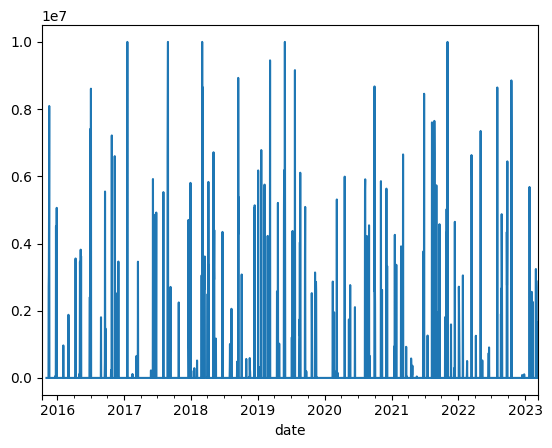

In [73]:
bitcoin_df_sarimax.st_rsi_7_over_14.plot()

### 2.1.3 Volatility Ratios <a id='2_1_3'></a>

In [75]:
day_1 = 7
day_2 = 30
day_3 = 150
bitcoin_df_sarimax[f'vol_ratio_{day_1}_over_{day_2}'] = bitcoin_df_sarimax[f'{day_1}_day_vol']/bitcoin_df_sarimax[f'{day_2}_day_vol']
bitcoin_df_sarimax[f'vol_ratio_{day_1}_over_{day_3}'] = bitcoin_df_sarimax[f'{day_1}_day_vol']/bitcoin_df_sarimax[f'{day_3}_day_vol']
bitcoin_df_sarimax[f'vol_ratio_{day_2}_over_{day_3}'] = bitcoin_df_sarimax[f'{day_2}_day_vol']/bitcoin_df_sarimax[f'{day_3}_day_vol']


In [80]:
bitcoin_df_sarimax['MACD_over'] = bitcoin_df_sarimax['MACD'] > bitcoin_df_sarimax['Signal Line']

### 2.1.4 Location in Terms of STD <a id='2_1_4'></a>

In [90]:
bitcoin_df_sarimax['vol'] = bitcoin_df_sarimax['close'].rolling(140).std()
bitcoin_df_sarimax['sma'] = bitcoin_df_sarimax['close'].rolling(140).mean()
bitcoin_df_sarimax['std_from_mean'] = (bitcoin_df_sarimax['close'] - bitcoin_df_sarimax['sma'])/bitcoin_df_sarimax['vol']


In [140]:
bitcoin_df_sarimax_with_all_features = bitcoin_df_sarimax.loc[:, [i for i in bitcoin_df_sarimax.columns if i not in  ['150_day_vol', '100_day_vol', '50_day_vol', '30_day_vol', '10_day_vol']]]
bitcoin_df_sarimax_with_all_features = bitcoin_df_sarimax_with_all_features.dropna()
bitcoin_df_sarimax_with_all_features = bitcoin_df_sarimax_with_all_features[['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD',
       'log_return', 'pct_return', 'bitcoin_return', 'MACD', 'Signal Line',
       'ha_close', 'ha_open', 'ha_high', 'ha_low', '5_day_vol',
       'rsi_7', 'rsi_14', 'rsi_30', 'rsi_14_over_30', 'rsi_7_over_30',
       'rsi_7_over_14', 'stochastic_rsi_7', 'stochastic_rsi_14',
       'stochastic_rsi_30', 'st_rsi_14_over_30', 'st_rsi_7_over_30',
       'st_rsi_7_over_14', 'vol_ratio_7_over_30', 'vol_ratio_7_over_150',
       'vol_ratio_30_over_150', 'MACD_over', 'vol', 'sma', 'std_from_mean', '7_day_vol']]


In [100]:
pwd

'/Users/liqingyang/Documents/GitHub/variance_prediction/data/cleaned_data'

### 2.1.5 Lasso To Select Features <a id='2_1_5'></a>

In [141]:
bitcoin_df_sarimax_with_all_features_selected = bitcoin_df_sarimax_with_all_features[['close', 'Volume BTC', 'Volume USD', '5_day_vol', 'rsi_14_over_30', 'rsi_7_over_30',
       'rsi_7_over_14', 'st_rsi_14_over_30', 'st_rsi_7_over_30',
       'st_rsi_7_over_14', 'vol_ratio_7_over_30', 'vol_ratio_7_over_150',
       'vol_ratio_30_over_150', 'MACD_over', 'std_from_mean', '7_day_vol']]
bitcoin_df_sarimax_with_all_features_selected['target'] = bitcoin_df_sarimax_with_all_features_selected['7_day_vol'].shift(-1)
bitcoin_df_sarimax_with_all_features_selected = bitcoin_df_sarimax_with_all_features_selected.dropna()

/var/folders/4m/qh070ww90rqgmcw604kkdt8r0000gn/T/ipykernel_37538/3073409490.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_df_sarimax_with_all_features_selected['target'] = bitcoin_df_sarimax_with_all_features_selected['7_day_vol'].shift(-1)


In [142]:
path = '/Users/liqingyang/Documents/GitHub/variance_prediction/data/cleaned_data/btc_1d_with_all_features.csv'
bitcoin_df_sarimax_with_all_features_selected.to_csv(path)

In [143]:
X = bitcoin_df_sarimax_with_all_features_selected.iloc[:, :-1]
y = bitcoin_df_sarimax_with_all_features_selected['target']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying Lasso regression
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train_scaled, y_train)

# Getting the coefficients
coefficients = lasso.coef_

# Identifying features with non-zero coefficients
significant_features = X.columns[coefficients != 0]
print('Significant features:', significant_features)


Significant features: Index(['close', 'Volume BTC', 'Volume USD', '5_day_vol', 'rsi_14_over_30',
       'rsi_7_over_14', 'vol_ratio_30_over_150', '7_day_vol'],
      dtype='object')


In [144]:
bitcoin_df_sarimax_with_selected_features = bitcoin_df_sarimax_with_all_features_selected[['close', 'Volume BTC', 'Volume USD', '5_day_vol', 'rsi_14_over_30', 
                                                                                          'rsi_7_over_14', 'vol_ratio_30_over_150', '7_day_vol', 'target']]
bitcoin_df_sarimax_with_selected_features

close   Volume BTC    Volume USD  5_day_vol  rsi_14_over_30  \
date                                                                         
2016-03-05    393.93  3085.475956  5.140633e+04   0.012628        0.464096   
2016-03-06    401.50   364.144701  5.927630e+03   0.022186        0.540183   
2016-03-07    412.04  2426.501107  4.128400e+04   0.026930        0.640948   
2016-03-08    412.09  1368.555389  2.343026e+04   0.026990        0.779819   
2016-03-09    411.00  3401.546586  5.813963e+04   0.023666        0.707895   
...              ...          ...           ...        ...             ...   
2023-03-06  22441.68   235.652360  2.204278e+05   0.017886        0.488703   
2023-03-07  22211.93   440.863300  4.085653e+05   0.017833        0.500007   
2023-03-08  21704.40   397.794102  3.653873e+05   0.010364        0.485093   
2023-03-09  20289.98  1644.085576  1.422081e+06   0.027898        0.448937   
2023-03-10  20215.95   818.994202  6.820123e+05   0.026621        0.502971   

            rsi_7_over_14  vol_ratio_30_over_150  7_day_vol    target  
date                                                                   
2016-03-05       0.540899               0.566766   0.017885  0.021320  
2016-03-06       0.834013               0.572994   0.021320  0.023761  
2016-03-07       0.771759               0.568524   0.023761  0.023934  
2016-03-08       0.688480               0.568466   0.023934  0.022044  
2016-03-09       0.923819               0.564374   0.022044  0.022505  
...                   ...                    ...        ...       ...  
2023-03-06       1.186195               1.015165   0.019501  0.019186  
2023-03-07       1.215775               1.010486   0.019186  0.015354  
2023-03-08       0.193158               1.017991   0.015354  0.024971  
2023-03-09       0.154633               1.073229   0.024971  0.023745  
2023-03-10       0.185067               1.071862   0.023745  0.032017  

[2562 rows x 9 columns]

In [145]:
path = '/Users/liqingyang/Documents/GitHub/variance_prediction/data/cleaned_data/btc_1d_with_selected_features.csv'
bitcoin_df_sarimax_with_selected_features.to_csv(path)

## 3. Modeling <a id='3'></a>
- Target variable is 7 day volatility

### 3.1 ARIMA <a id='3_1'></a>

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


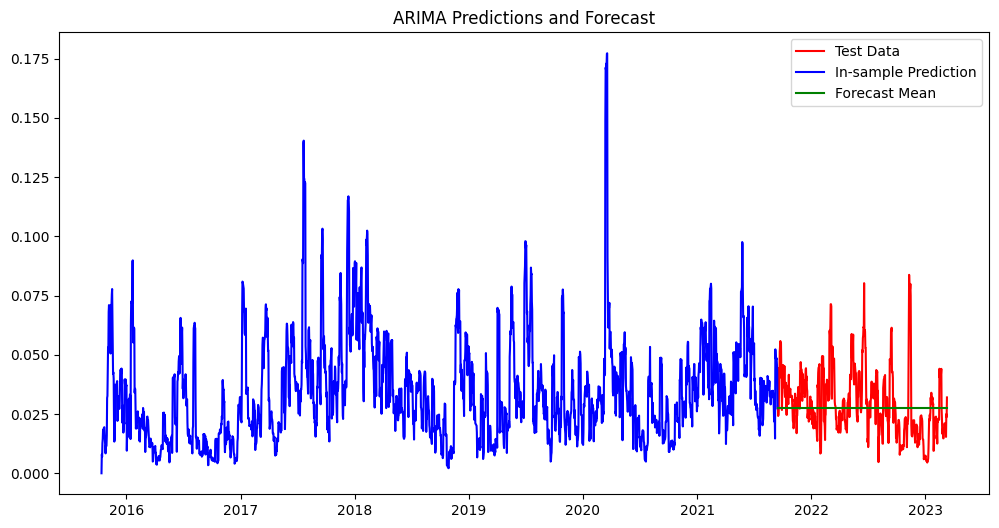

In [4]:
# Setting target to 7_day_vol
data = bitcoin_df['7_day_vol'].dropna()
# Splitting the data into training and testing sets
split_ratio = 0.8
split_index = int(len(data) * split_ratio)
train_data = data[:split_index]
test_data = data[split_index:]

model = ARIMA(train_data, order=(1, 1, 1))
fitted_model = model.fit()

# Forecast
# In-sample prediction with out-of-sample extension
in_sample_predictions = fitted_model.get_prediction(start=train_data.index[0], end=train_data.index[-1])
out_of_sample_forecast = fitted_model.get_forecast(steps=len(test_data))

# Getting the predicted means
in_sample_mean = in_sample_predictions.predicted_mean
out_of_sample_mean = out_of_sample_forecast.predicted_mean

# Plotting
plt.figure(figsize=(12, 6))
# plt.plot(train_data.index, train_data, label='Training Data', color='black')
plt.plot(test_data.index, test_data, label='Test Data', color='red')
plt.plot(train_data.index, in_sample_mean, label='In-sample Prediction', color='blue')
plt.plot(test_data.index, out_of_sample_mean, label='Forecast Mean', color='green')
plt.title('ARIMA Predictions and Forecast')
plt.legend()
plt.show()



# forecast = fitted_model.get_forecast(steps=len(test_data))
# forecast_mean = forecast.predicted_mean
# confidence_intervals = forecast.conf_int()  # Getting the confidence intervals

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(train_data.index, train_data, label='Training Data')
# plt.plot(test_data.index, test_data, label='Test Data', color='red')
# plt.plot(test_data.index, forecast_mean, label='Forecast Mean', color='green')

# # Plotting the confidence intervals
# plt.fill_between(test_data.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

# plt.title('ARIMA Forecast vs Actuals')
# plt.legend()
# plt.show()

In [80]:
min_train_size = 30  # Set a minimum training data size
traditional_forecast = np.array([])
dynamic_forecast = np.array([])
current_train_data = train_data.copy().to_numpy()
# current_train_data_dynamic = train_data.copy().to_numpy()
index_to_use = split_index

for t in range(len(test_data)):
    model = ARIMA(current_train_data, order=(1, 1, 1))
    fitted_model_trad = model.fit()

    # For dynamically predicted data
    model = ARIMA(data[:index_to_use], order=(1, 1, 1))
    fitted_model_dynamic = model.fit()

    # Forecast the next time step
    next_step_forecast_trad = fitted_model_trad.forecast()
    next_step_forecast_dyna = fitted_model_dynamic.forecast()
    
    traditional_forecast = np.append(traditional_forecast, next_step_forecast_trad[0])
    dynamic_forecast = np.append(dynamic_forecast, next_step_forecast_dyna[0])
    
    current_train_data = np.append(current_train_data, next_step_forecast_trad[0])
    index_to_use += 1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

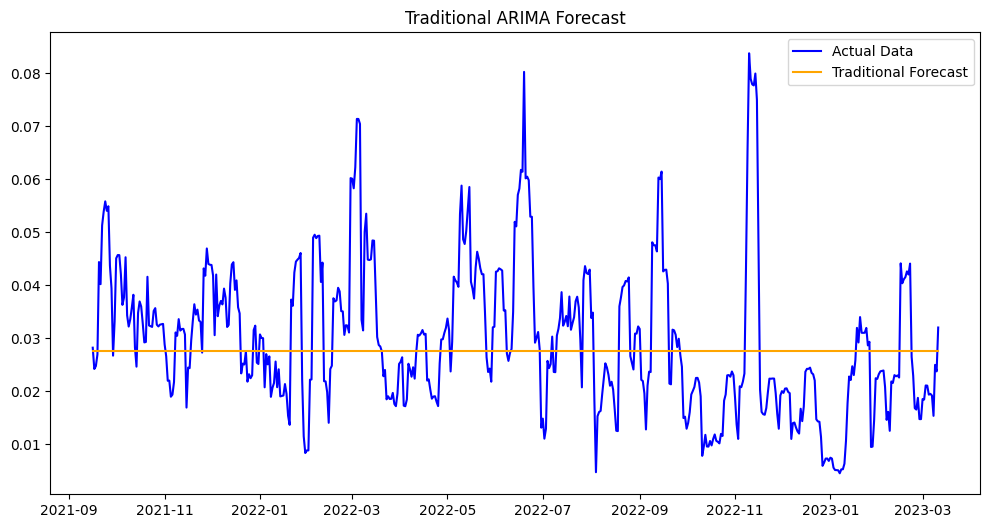

In [96]:
# Set the indices to match the forecasts with the dates
dynamic_forecast_index = data.index[split_index:]

# Plot the dynamic forecast against the test data
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data', color='blue')
plt.plot(test_data.index, traditional_forecast, label='Traditional Forecast', color='orange')
plt.title('Traditional ARIMA Forecast')
plt.legend()
plt.show()

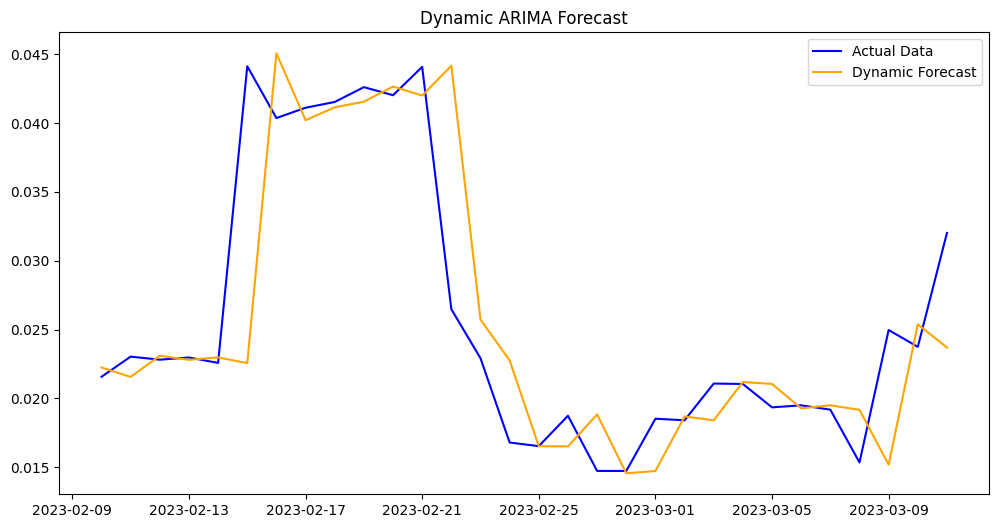

In [98]:
# Set the indices to match the forecasts with the dates
dynamic_forecast_index = data.index[split_index:]

# Plot the dynamic forecast against the test data
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[-30:], test_data[-30:], label='Actual Data', color='blue')
plt.plot(test_data.index[-30:], dynamic_forecast[-30:], label='Dynamic Forecast', color='orange')
plt.title('Dynamic ARIMA Forecast')
plt.legend()
plt.show()

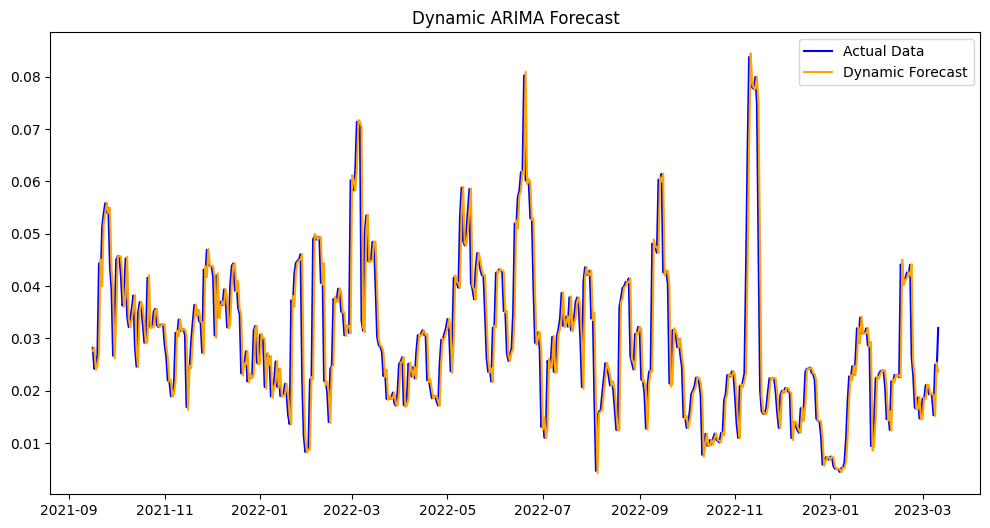

In [61]:
# Set the indices to match the forecasts with the dates
dynamic_forecast_index = data.index[split_index:]

# Plot the dynamic forecast against the test data
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data', color='blue')
plt.plot(test_data.index, dynamic_forecast, label='Dynamic Forecast', color='orange')
plt.title('Dynamic ARIMA Forecast')
plt.legend()
plt.show()

#### 3.1.1 Hyperparameters Tuning for ARIMA <a id='3_1_1'></a>

In [ ]:
p_values = [1, 2, 3, 4, 5]
d_values = [1, 2, 3, 4, 5]
q_values = [1, 2, 3, 4, 5]

# Evaluate models and get results DataFrame
# Target is 7_day_vol
data = bitcoin_df['7_day_vol'].dropna()
results_df = evaluate_models_with_existing(data, p_values, d_values, q_values)

Grid Search:   0%|                                       | 0/70 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/4m/qh070ww90rqgmcw604kkdt8r0000gn/T/ipykernel_64302/2026068227.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test[t])
/Library/Frameworks/Python.framework/Versions/

In [ ]:
results_df

In [109]:
results_df.iloc[0, -1]

[0.027664497449579568,
 0.028212804407686667,
 0.024194707656415522,
 0.024740742584455227,
 0.026931669614313,
 0.04436689244976265,
 0.04019247694223939,
 0.05128183800029595,
 0.053892556891396284,
 0.05581340588264574,
 0.05403153578869398,
 0.0548981019763315,
 0.0436546341585061,
 0.039427566686544346,
 0.026709449328255797,
 0.0332066054626164,
 0.04507545901834152,
 0.04568572723958634,
 0.04567452520123431,
 0.04207731350122086,
 0.03629026862957626,
 0.03769220427768382,
 0.045270861035828495,
 0.034311069201800354,
 0.03219526978692597,
 0.033567283528770954,
 0.03577768836547194,
 0.03819325598493121,
 0.028302130116723997,
 0.024634681229346242,
 0.03477855524000212,
 0.03693495716868085,
 0.03597644705877709,
 0.032803248263835946,
 0.02920482827090358,
 0.029291560884405002,
 0.0415867841368148,
 0.03240582368693439,
 0.032268859420990614,
 0.03212976822987942,
 0.03514853234516494,
 0.03567072022908079,
 0.03254873559727555,
 0.032216321625292615,
 0.03256010643550878,


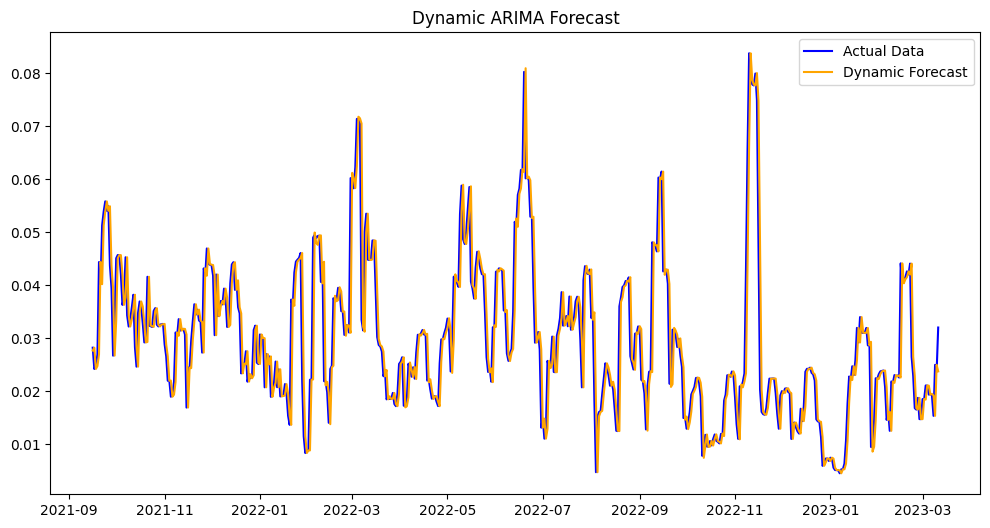

In [110]:
# Set the indices to match the forecasts with the dates
dynamic_forecast_index = data.index[split_index:]

# Plot the dynamic forecast against the test data
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data', color='blue')
plt.plot(test_data.index, results_df.iloc[0, -1], label='Dynamic Forecast', color='orange')
plt.title('Dynamic ARIMA Forecast')
plt.legend()
plt.show()

### 3.2 Sarimax <a id='3_2'></a>

In [3]:
path = '/Users/liqingyang/Documents/GitHub/variance_prediction/data/cleaned_data/btc_1d_engineered_selected_features.csv'
data = pd.read_csv(path, index_col=0)
data = data.loc[:, [i for i in data.columns if i != '7_day_vol']]
exog = data.iloc[:, :-1]
target = data.iloc[:, -1]

#### Static Prediction

In [157]:
# Load the data
path = '/Users/liqingyang/Documents/GitHub/variance_prediction/data/cleaned_data/btc_1d_engineered_selected_features.csv'
data = pd.read_csv(path, index_col=0)
data.index = pd.to_datetime(data.index)  # Ensure the index is datetime

# Prepare exogenous and target variables
exog = data.iloc[:, :-1]
target = data.iloc[:, -1]

# Split the data into training and testing sets
split_point = int(len(data) * 0.8)  # 80% for training
train_exog = exog.iloc[:split_point]
test_exog = exog.iloc[split_point:]
train_target = target.iloc[:split_point]
test_target = target.iloc[split_point:]

# Define and fit the SARIMAX model
model = SARIMAX(train_target, exog=train_exog, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
results = model.fit()

# Make predictions
predictions = results.forecast(steps=len(test_target), exog=test_exog)

# Optionally, compare predictions with the actual values
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_target, predictions)
print(f'Mean Squared Error: {mse}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.38193D+00    |proj g|=  1.70472D+11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      1     21      1     0     0   1.705D+11  -3.382D+00
  F =  -3.3819282156732995     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Mean Squared Error: 0.00019178910106127305


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


<Axes: xlabel='date'>

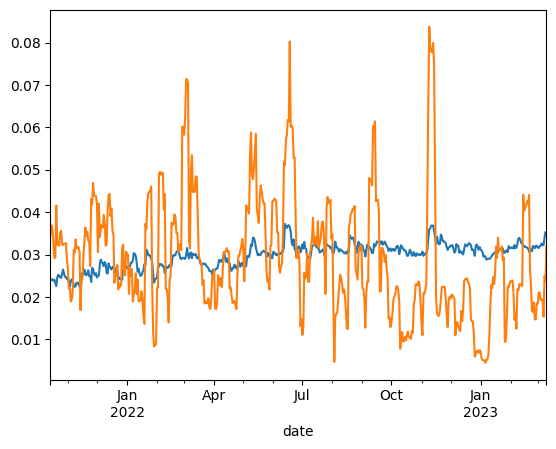

In [158]:
predictions.plot()
y_test.plot()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.40006D+00    |proj g|=  1.88182D+11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      1     21      1     0     0   1.882D+11  -3.400D+00
  F =  -3.4000580043016999     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


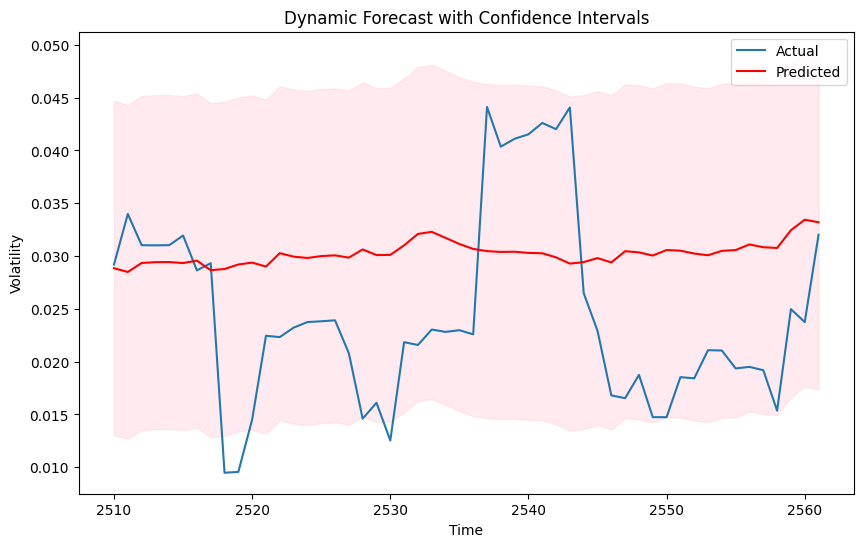

In [4]:
# Fit the SARIMAX model
# Prepare exogenous and target variables
exog = data.iloc[:, :-1]
target = data.iloc[:, -1]

# Split the data into training and testing sets
split_point = int(len(data) * 0.9)  # 80% for training
train_exog = exog.iloc[:split_point]
# test_exog = exog.iloc[split_point:]
train_target = target.iloc[:split_point]
# test_target = target.iloc[split_point:]

model = SARIMAX(train_target, exog=train_exog, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
results = model.fit()

# Predict dynamically using the actual data
split_point = len(data) - int(len(data) * 0.98)
n_forecasts = split_point  # Number of steps to forecast dynamically
predictions = []
lower_bounds = []
upper_bounds = []

for i in range(len(target) - n_forecasts, len(target)):
    endog = target[:i]  # Endogenous data up to point i
    exog_future = exog.iloc[[i]]  # Exogenous data at point i

    # Get forecast 1 step ahead
    forecast = results.get_forecast(steps=1, exog=exog_future)
    forecasted_value = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # Collect the forecast and confidence intervals
    predictions.append(forecasted_value.values[0])
    lower_bounds.append(conf_int.iloc[0, 0])
    upper_bounds.append(conf_int.iloc[0, 1])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
times = range(len(target) - n_forecasts, len(target))
ax.plot(times, target.iloc[-n_forecasts:], label='Actual')
ax.plot(times, predictions, label='Predicted', color='r')
ax.fill_between(times, lower_bounds, upper_bounds, color='pink', alpha=0.3)
ax.set_title('Dynamic Forecast with Confidence Intervals')
ax.set_xlabel('Time')
ax.set_ylabel('Volatility')
ax.legend()
plt.show()

#### Dynamic Prediction

In [6]:
# Fit the SARIMAX model
# Prepare exogenous and target variables
exog = data.iloc[:, :-1]
target = data.iloc[:, -1]

# Predict dynamically using the actual data
initial_train_size = int(len(target) * 0.95)
# train_target = target[:initial_train_size]
# train_exog = exog[:initial_train_size]

# Fit the initial model
# model = SARIMAX(train_target, exog=train_exog, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
# results = model.fit()

# Predict dynamically and update the model as new data comes in
predictions = []
lower_bounds = []
upper_bounds = []
actuals = target[initial_train_size:]  # Actual values to compare against predictions
index = initial_train_size

for new_index in range(initial_train_size, len(target)):
    # Update model with new data point
    new_target = target[:new_index]
    new_exog = exog[:new_index]
    model_updated = SARIMAX(new_target, exog=new_exog, order=(3, 2, 3), seasonal_order=(0, 0, 0, 0))
    results_updated = model_updated.fit(disp=0)  # disp=0 hides output from the fit method

    # Predict the next point
    exog_future = exog.iloc[[new_index]]  # Exogenous data at the new point
    forecast = results_updated.get_forecast(steps=1, exog=exog_future)
    predicted_value = forecast.predicted_mean.item()
    conf_int = forecast.conf_int()

    # Collect the forecast and confidence intervals
    predictions.append(predicted_value)
    lower_bounds.append(conf_int.iloc[0, 0])
    upper_bounds.append(conf_int.iloc[0, 1])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Fra

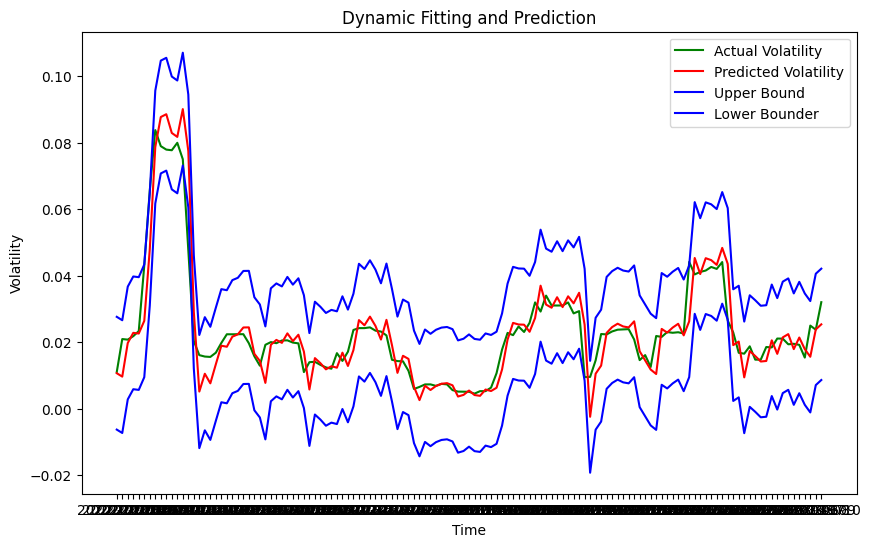

In [7]:
# Plotting the results
# predictions = [predictions[i] for i in range(0, len(predictions), 2)]
plt.figure(figsize=(10, 6))
plt.plot(target.index[initial_train_size:], actuals, label='Actual Volatility', color='green')
plt.plot(target.index[initial_train_size:], predictions, label='Predicted Volatility', color='r')
plt.plot(target.index[initial_train_size:], upper_bounds, label='Upper Bound', color='blue')
plt.plot(target.index[initial_train_size:], lower_bounds, label='Lower Bounder', color='blue')

plt.title('Dynamic Fitting and Prediction')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [8]:
print("RMSE:", rmse(predictions, actuals))
print("MAE:", mae(predictions, actuals))
print("MAPE:", mape(predictions, actuals))
print("Theil U Statistic:", theil_u_statistic(predictions, actuals))

NameError: name 'rmse' is not defined